In [2]:
!pip install mnist
!pip install tensorly
!pip install cvxpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import sys
from random import seed
np.random.seed(1)
seed(1)
import numpy as np
from scipy.optimize import linprog
import cvxopt
import mnist
import tensorly as tl
from tensorly.decomposition import parafac
import os
import cv2

In [4]:
def centroid(points):
    c = np.zeros(points.shape[1:])
    for i in range(points.shape[0]):
        c = c + points[i]
    return c/points.shape[0]


def visualise(w,shape):
    wsq=w.copy()
    wsq=np.reshape(wsq,shape)
    plt.imshow(wsq, interpolation='nearest',cmap='gray')
    plt.show()

def visualise_pos(w,shape):
    
    wsq=w.copy()
    wsq=np.maximum(wsq, 0)
    wsq = (wsq - np.min(wsq)) / (np.max(wsq) - np.min(wsq))
    wsq=np.reshape(wsq,shape)
    plt.imshow(wsq, interpolation='nearest',cmap='gray')
    plt.show()

def visualise_neg(w,shape):
    
    wsq=w.copy()
    wsq=np.minimum(wsq, 0)
    wsq = (wsq - np.min(wsq)) / (np.max(wsq) - np.min(wsq))
    wsq=np.reshape(wsq,shape)
    plt.imshow(wsq, interpolation='nearest',cmap='gray')
    plt.show()
    

def redoer(image, shape = (20,20), interpolation = cv2.INTER_CUBIC):
    assert(len(shape)==2)
    new_shape = (shape[1],shape[0])
    shape=new_shape
    reimage = cv2.resize(image, shape, interpolation=interpolation)
    if len(reimage.shape)==3:
        reimage = reimage.reshape((reimage.shape[0],reimage.shape[1]*reimage.shape[2]))
    return reimage
    

In [5]:
def inner_mat(A, B, M = None):
    assert(A.shape==B.shape)
    M = A.shape[0] if M is None else M
    M = min(M, A.shape[0])
    mat = np.ones((M,M))
    for i in range(M):
        for j in range(M):
            xi = A[i]
            xj = B[j]
            mat[i,j] = np.sum(xi*xj)
    return mat
def inner_prod_cp(w,x):
    return cp.sum(cp.multiply(w,x))
def inner_prod(A, B):
    if A.shape == B.shape:
        return np.sum(A*B)
    if A.shape == B.shape[1:]:
        ans = []
        for b in B:
            ans.append(np.sum(A*b))
        return ans

In [6]:
def predict(X, w, b):
  return np.sign(inner_prod(w, X)+b).reshape(-1,1)
def accuracy(a,b):
  n=0
  for i in range(len(a)):
    if(a[i]==b[i]):
      n=n+1
  return n/len(a)
def getHyperPlaneFromTwoPoints(x1, x2):
  assert(x1.shape[0]==x2.shape[0])
  d = x1.shape[0]
  w = (2 + 1e-8) * (x2 - x1) / (np.linalg.norm(x1 - x2) ** 2)
  #b = - np.dot(w , (0.5 * (x1 + x2)))
  b = inner_prod(w,(0.5 * (x1 + x2)))  
  return w, b

In [7]:
def solver(X, y, C = 1, method='MCM_STM', r = None, flag = True, xa = None, xb = None, methodw = 'L2', methodq = 'L1'):
    return tensor_MCM(X, y, rank=r, C=C, xa = xa, xb = xb)
    method = 'MCM_STM'
    y = y.reshape(-1,1)
    assert(X.shape[0]==y.shape[0])
    if flag==False or len(X.shape)==2:
        if method == 'STM' or method == 'SHTM' or method == 'MCM_STM':
            w = np.ones(X.shape[1:])
            b = np.ones(y.shape[1:])
            M = X.shape[0]
            if method == 'STM':
                H = np.dot(y,y.T)*inner_mat(X,X)*1.0
            elif method == 'SHTM':
                r = r if r is not None else 1
                H = np.dot(y,y.T)*inner_mat(X, X, r, method='SHTM')*1.0
            P_ = cvxopt.matrix(H)
            q_ = cvxopt.matrix(-np.ones((M,1)))
            G_ = cvxopt.matrix(np.vstack((np.eye(M)*-1,np.eye(M))))
            h_ = cvxopt.matrix(np.hstack((np.zeros(M), np.ones(M)*C)))
            A_ = cvxopt.matrix(y.reshape(1,-1).astype('float'))
            b_ = cvxopt.matrix(np.zeros(1)) 
            sol = cvxopt.solvers.qp(P_, q_, G_, h_, A_, b_, options={'show_progress': False})
            alphas = np.array(sol['x'])
            w = np.tensordot((y*alphas).T, X, axes = ((1),(0))).reshape(X.shape[1:]) 
            b = -0.5*(max(inner_prod(w, X[(y==-1).reshape(-1)])) + min(inner_prod(w, X[(y==1).reshape(-1)])))
            return w, b
    else:
        #only works for greyscale right now
        xa = xa if xa is not None else np.zeros(X.shape[0])
        xb = xb if xb is not None else np.zeros(X.shape[0])
        assert(xa is not None)
        assert(xb is not None)
        assert(len(X.shape)<=3)
        if len(X.shape)==3:
            if method == 'MCM_STM':
                w = cp.Variable(X.shape[1:])
                b = cp.Variable((1,1))
                wa = cp.Variable((1,1))
                wb = cp.Variable((1,1))
                qi = cp.Variable(y.shape)
                h = cp.Variable((1,1))
                if methodq == 'L1':
                    term2 = cp.sum(qi)*C
                elif methodq == 'L0':
                    term2 = 0
                    for i in range(y.shape[0]):
                        term2 += cp.maximum(0,cp.sign(qi[i]))*C
                objfun = cp.Minimize(h + term2)
                constraints = []
                maxes = np.max(X, axis=0)
                mines = np.min(X, axis= 0)
                for i in range(X.shape[1]):
                    for j in range(X.shape[2]):
                        constraints+=[w[i][j]<=maxes[i][j], mines[i][j]<=w[i][j]]
                for i in range(X.shape[0]):
                    constraints+=[cp.multiply(y[i],(inner_prod_cp(w,X[i]) + b + cp.multiply(wa,xa[i]) + cp.multiply(wb,xb[i])))+qi[i] >= 1.0, \
                        cp.multiply(y[i],(inner_prod_cp(w,X[i]) + b + cp.multiply(wa,xa[i]) + cp.multiply(wb,xb[i])))+qi[i] <= h, qi[i]>=0]
                problem = cp.Problem(objfun,constraints)
                problem.solve(verbose=False)
                return w.value, b.value, wa.value, wb.value
            if method == 'STM' or method == 'SHTM':
                w = cp.Variable(X.shape[1:])
                b = cp.Variable((1,1))
                wa = cp.Variable((1,1))
                wb = cp.Variable((1,1))
                qi = cp.Variable(y.shape)
                if methodq == 'L1':
                    term2 = cp.sum(qi)*C
                elif methodq == 'L0':
                    term2 = 0
                    for i in range(y.shape[0]):
                        term2 += cp.maximum(0,cp.sign(qi[i]))*C
                if methodw == 'L2':
                    term1 = 1/2*cp.norm2(w)
                    term3 = 1/2*(cp.square(wa)+cp.square(wb))
                elif methodw == 'L1':
                    term1 = cp.norm1(w)
                    term3 = cp.abs(wa)+cp.abs(wb)
                elif methodw == 'L0':
                    term1 = 0
                    for i in range(X.shape[1]):
                        for j in range(X.shape[2]):
                            term1 += cp.maximum(0,cp.sign(w[i][j]))
                    term3 = cp.maximum(0,cp.sign(wa))+cp.maximum(0,cp.sign(wb))
                objfun = cp.Minimize(term1+term2+term3)
                constraints = []
                #constraints = y*(inner_prod_cp(w,X) + b + wa*xa + wb*xb) + qi >= 1
                #constraints += qi>=0
                maxes = np.max(X, axis=0)
                mines = np.min(X, axis= 0)
                for i in range(X.shape[1]):
                    for j in range(X.shape[2]):
                        constraints+=[w[i][j]<=maxes[i][j], mines[i][j]<=w[i][j]]
                for i in range(X.shape[0]):
                    constraints+=[cp.multiply(y[i],(inner_prod_cp(w,X[i]) + b + cp.multiply(wa,xa[i]) + cp.multiply(wb,xb[i])))+qi[i]>=1, qi[i]>=0]
                problem = cp.Problem(objfun,constraints)
                problem.solve()
                return w.value, b.value, wa.value, wb.value

In [22]:
###Solver 2
def rank_R_decomp(X, rank=3):
    X_t = tl.tensor(X)
    _, factors = parafac(X_t, int(rank))
    fact_np = [tl.to_numpy(f) for f in factors]
    return fact_np


def inner_prod_decomp(Ai, Aj, gamma = 10):
  s = 0.0
  R = Ai[0].shape[1]
  for p in range(R):
    for q in range(R):
      prod = 1.0
      for ai, aj in zip(Ai, Aj):  
        prod *= np.dot(ai[:, p], aj[:, q])
        #prod *= np.exp(-gamma*np.sum((ai[:, p] -aj[:, q])**2))
      s += prod
  return s

def make_kernel(data_decomp):
  K = np.zeros((len(data_decomp), len(data_decomp)))
  for i in range(len(data_decomp)):
    for j in range(i+1):
      K[i, j] = inner_prod_decomp(data_decomp[i], data_decomp[j])
      K[j, i] = K[i, j]
  
  return K
#x, y, C = 1, method='MCM_STM', r = None, flag = True, xa = None, xb = None, methodw = 'L2', methodq = 'L1'
def tensor_MCM(data_X, data_Y, rank=3.0, C=1.0, xa = None, xb = None):
  M = len(data_X)
  xa = xa if xa is not None else np.zeros(M)
  xb = xb if xb is not None else np.zeros(M)
  rank = 3.0 if rank is None else rank
  data_fact = [rank_R_decomp(X, rank) for X in data_X]
  K = make_kernel(data_fact)

  h = cp.Variable()
  b = cp.Variable()
  q = cp.Variable(M)
  l = cp.Variable(M)
  wa = cp.Variable((1,1))
  wb = cp.Variable((1,1))

  obj = h + C*cp.atoms.affine.sum.sum(q)

  constraints = []
  for i in range(M):
    constraints.append(h >= (data_Y[i]*(cp.sum(l*K[:, i])+b+cp.multiply(wa,xa[i]) + cp.multiply(wb,xb[i])) + q[i]))
    constraints.append((data_Y[i]*(cp.sum(l*K[:, i]) + b+cp.multiply(wa,xa[i]) + cp.multiply(wb,xb[i])) + q[i]) >= 1)
    constraints.append(q[i] >= 0)
  
  constraints.append(l >= -1/M)
  constraints.append(l <= 1/M)

  prob = cp.Problem(cp.Minimize(obj), constraints)
  prob.solve()

  print('The optimal value is:', prob.value)
  
  W = tl.to_numpy(construct_W(data_fact, l.value, 1e-9))
#################
#should W be decomposed as well?
#W_decomp = [w.squeeze() for w in rank_R_decomp(W, 1)]

  print(W.shape)  
  return W, b.value, wa.value, wb.value
def construct_W(data_decomp, l, eps=1e-100):
  R = data_decomp[0][1].shape[1]
  W = tl.zeros([data_decomp[0][i].shape[0] for i in range(len(data_decomp[0]))])
  for i, flag in enumerate((np.abs(l) > eps)):
    if flag:
      W += l[i]*tl.cp_to_tensor((np.ones(R), data_decomp[i]))
  
  return W


In [23]:
class Node:
  def __init__(self,inp_dimensions):
    self.weight = np.zeros(inp_dimensions)
    self.bias = 0
    self.A = None
    self.B = None
    self.wA = 0
    self.wB = 0
    self.dim = inp_dimensions
    self.C1=[]
    self.C2=[]
    self.C3=[]
    self.C4=[]
    self.labels = []
    self.X = []
    self.height = 0
  def insert(self,neuron_type, weight=0, bias=0, w=0):     
    if neuron_type == 'A':
      self.A = Node(self.dim)
      self.A.weight = weight
      self.A.bias = bias
      self.A.height = self.height+1
      return self.A
    else:
      self.B = Node(self.dim)
      self.B.weight = weight
      self.B.bias = bias
      self.B.height = self.height+1
      return self.B
  def update_weights_and_bias(self,weight, bias, wA = 0, wB = 0):  
    self.weight = weight
    self.bias = bias
    self.wA = wA
    self.wB = wB
  def update_classes(self,ypred,ytrue):
    ypred=ypred.copy()
    ypred=np.reshape(ypred,(ypred.shape[0],1))    
    yf  = np.add(2*ypred, ytrue)
    self.C1 = np.argwhere(yf>2)[:,0] #1,1              #In order: predicted, true
    self.C2 = np.argwhere(yf<-2)[:,0] #-1,-1
    self.C3 = np.where((yf<2) & (yf>0))[0]   #1,-1
    self.C4 = np.where((yf<0) & (yf>-2))[0] #-1,1
  def forward(self, X): 
    
    y=[]
    X=X.copy()
    w = self.weight 
    b = self.bias
    wA = np.asarray([self.wA]).copy()
    wB=np.asarray([self.wB]).copy()

    if(self==None):
      return [] 
    if(self.A==None and self.B==None):

      y = np.sign(np.array(inner_prod(w, X))+np.array(b)).reshape(-1,1)
    if(self.A==None):
      xA = np.zeros((X.shape[0],1))
    else:
      xA = self.A.forward(X)
      xA=np.reshape(xA,(xA.shape[0],1))
    if(self.B==None):
      xB = np.zeros((X.shape[0],1)) 
    else:
      xB = self.B.forward(X)
      xB=np.reshape(xB,(xB.shape[0],1))
    if(self.A!=None and self.B!=None):

      wA = np.asarray([wA.item()])
      wB = np.asarray([wB.item()])

      y = np.sign(np.asarray(inner_prod(w, X))+np.asarray(inner_prod(wA, xA))+np.asarray(inner_prod(wB, xB))+np.asarray(b)).reshape(-1,1)
    if(self.A!=None and self.B==None):

      wA = np.asarray([wA.item()])
      y = np.sign(np.asarray(inner_prod(w, X))+np.asarray(inner_prod(wA, xA))+np.asarray(b)).reshape(-1,1)
    if(self.A==None and self.B!=None):

      wB = np.asarray([wB.item()])
      y = np.sign(np.asarray(inner_prod(w, X))+np.asarray(inner_prod(wB, xB))+np.asarray(b)).reshape(-1,1)

    return y
    
  
    
      

  def fine_tune_weights(self,C, methodw, methodq):
    l=self.labels.copy()
    X = self.X.copy()
    xA = np.zeros((X.shape[0],1))
    xB = np.zeros((X.shape[0],1))
    if(self==None):
      return   
    if(self.A!=None):
      self.A.fine_tune_weights(C, methodw=methodw, methodq=methodq)  
      xA = self.A.forward(X)
      xA=np.reshape(xA,(xA.shape[0],1))

    if(self.B!=None):
      self.B.fine_tune_weights(C, methodw=methodw, methodq=methodq) 
      xB = self.B.forward(X)
      xB=np.reshape(xB,(xB.shape[0],1))
    weight, bias, wA, wB = solver(X,l,C,'STM',None,True,xA,xB, methodw=methodw, methodq=methodq)
    print(self.height)
    visualise(weight,(X.shape[1],X.shape[2]))
    visualise_pos(weight,(X.shape[1],X.shape[2]))
    visualise_neg(weight,(X.shape[1],X.shape[2]))##THis is hard coded assuming Grayscale Images

    self.update_weights_and_bias(weight, bias,wA,wB)


  def recursive(self, X,labels, h,C, methodw, methodq):
    self.X = X
    self.labels = labels
    labels=labels.copy()
    X=X.copy()
    weight, bias, _, _1_ = solver(X,labels,C, methodw=methodw, methodq=methodq)
    self.update_weights_and_bias(weight, bias)
    ypred=self.forward(X)
    self.update_classes(ypred,labels)
    C1=self.C1
    C2=self.C2
    C3=self.C3
    C4=self.C4
    if(len(C3)==0 and len(C4)==0):
      return
    if(self.height>h-1):
      return
    if(len(C1)==0 or len(C2)==0):
      if(len(C1)!=0):
        X_positive=np.take(X,np.hstack((C1,C4)),axis=0) 
        X_negative=np.take(X,np.hstack((C3)),axis=0)
        #x1=X[C1[0]]
        #x2=X[C3[0]]
      elif(len(C2)!=0):
        X_positive=np.take(X,np.hstack((C4)),axis=0)  
        X_negative=np.take(X,np.hstack((C2,C3)),axis=0)
        #x1=X[C2[0]]
        #x2=X[C4[0]]
      else:
        #x1=X[C3[0]]
        #x2=X[C4[0]]
        X_positive=np.take(X,np.hstack((C4)),axis=0)  
        X_negative=np.take(X,np.hstack((C3)),axis=0)
      x1 = centroid(X_positive)
      x2 = centroid(X_negative)
      weight, bias = getHyperPlaneFromTwoPoints(x1, x2)
      self.update_weights_and_bias(weight, bias)
      ypred = self.forward(X)
      self.update_classes(ypred,labels)
      C1=self.C1
      C2=self.C2
      C3=self.C3
      C4=self.C4

    if(len(C3)!=0):
      X_new=np.take(X,np.hstack((C1,C3,C4)),axis=0)
      labels[C1]=-1
      labels[C3]=1
      labels[C4]=-1
      y_new=np.take(labels,np.hstack((C1,C3,C4)),axis=0)
      NodeA = self.insert('A')
      NodeA.recursive(X_new,y_new,h,C, methodw=methodw, methodq=methodq)
    if(len(C4) != 0):
      X_new=np.take(X,np.hstack((C2,C3,C4)),axis=0)
      labels[C2]=-1
      labels[C3]=-1
      labels[C4]=1
      y_new=np.take(labels,np.hstack((C2,C3,C4)),axis=0)
      NodeB = self.insert('B')
      NodeB.recursive(X_new,y_new,h,C, methodw=methodw, methodq=methodq)

In [24]:
def train(X,y,height = 1000,C=1000000, methodw = 'L2', methodq = 'L1'):
  print("Start")
  Tree = Node(X.shape[1:])

  Tree.recursive(X,y,height,C, methodw=methodw, methodq=methodq)
  print("Recursion Done")

  Tree.fine_tune_weights(C, methodw=methodw, methodq=methodq)
  print("End")

  ypred=Tree.forward(X)
  print("Train accuracy:")
  print(accuracy(y,ypred))
  return Tree

In [25]:
XALL = mnist.train_images()[:5000]/255
yALL = mnist.train_labels().reshape(-1,1)[:5000].astype(np.int8)
y0 = (yALL == 3)
y2 = (yALL == 8)
ytot = y0 + y2
Xtrain = XALL[ytot.reshape(-1)]
ytrain = (yALL[ytot.reshape(-1)] -5.5)/2.5

0 fold
Start
The optimal value is: 1031543.8211368725
(28, 28)
The optimal value is: 368576.1921413489
(28, 28)
The optimal value is: 267822.88359946787
(28, 28)
Recursion Done
The optimal value is: 368576.191945992
(28, 28)
1


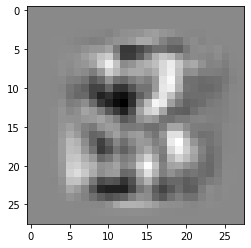

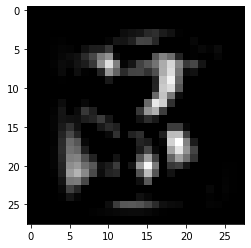

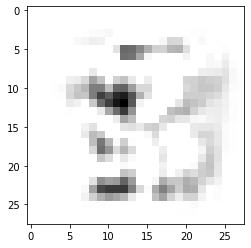

The optimal value is: 267822.88359946787
(28, 28)
1


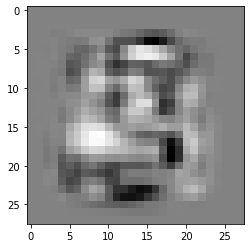

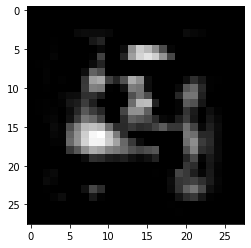

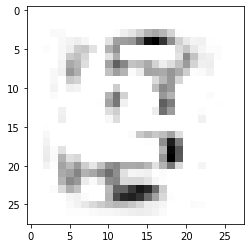

The optimal value is: 1031552.0304251044
(28, 28)
0


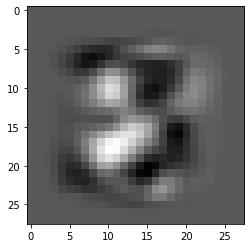

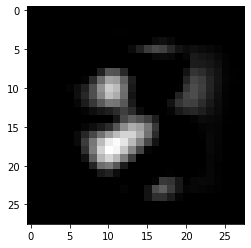

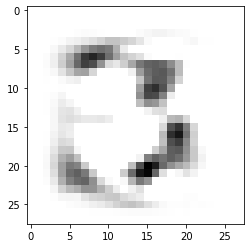

End
Train accuracy:
0.9528795811518325
Test Accuracy:
0.9633507853403142


total test accuracy=0.9633507853403142




In [26]:
n = Xtrain.shape[0]
i = 0
k = 1
r = int(n/5)
total_correct = 0
total_total = 0
total_accuracy = 0
while(i < k):
    print(f"{i} fold")
    if ((i+1)*r>n):
        print("lower the test %")
        break
    Xtra1 = Xtrain[0 : r*i]
    Ytra1 = ytrain[0 : r*i]
    Xtra2 = Xtrain[r*(i+1) : ]
    Ytra2 = ytrain[r*(i+1) : ]
    Xtra = np.concatenate((Xtra1, Xtra2), axis=0)
    Ytra = np.concatenate((Ytra1, Ytra2), axis=0)
    Xtest = Xtrain[r*i : r*(i+1)]
    Ytest = ytrain[r*i : r*(i+1)]
    model = train(Xtra,Ytra,1,10000,'L1','L1')
    ypred = model.forward(Xtest)
    acc = accuracy(ypred,Ytest)
    total_accuracy += acc
    print('Test Accuracy:')
    print(acc)
    i+=1
    print('\n')
print(f"total test accuracy={total_accuracy/k}\n\n")

0 fold
Start
The optimal value is: 10320.12239408565
(28, 28)
The optimal value is: 3687.7232031204685
(28, 28)
The optimal value is: 3516.593220213706
(28, 28)
The optimal value is: 2279.570331468695
(28, 28)
The optimal value is: 2680.1659165797337
(28, 28)
The optimal value is: 2680.165916579729
(28, 28)
The optimal value is: 11.637150601199538
(28, 28)
Recursion Done
The optimal value is: 3516.5932202137124
(28, 28)
2


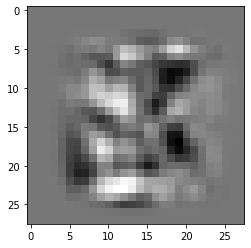

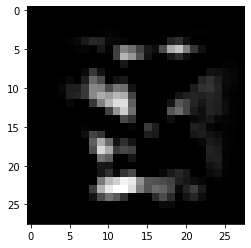

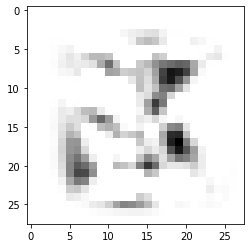

The optimal value is: 2279.5703314686953
(28, 28)
2


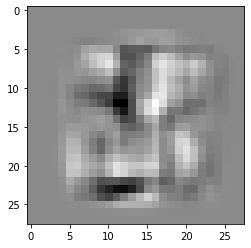

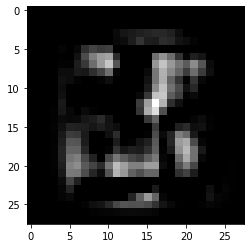

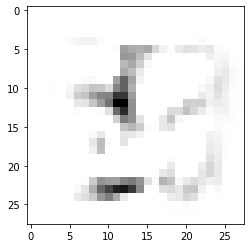

The optimal value is: 3558.390668821466
(28, 28)
1


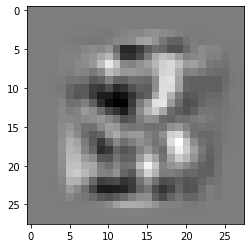

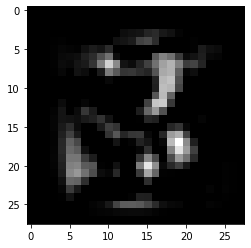

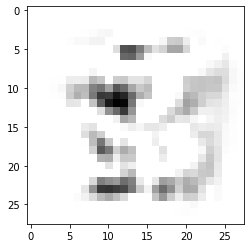

The optimal value is: 2680.1659165797273
(28, 28)
2


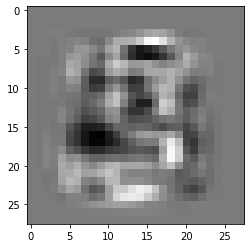

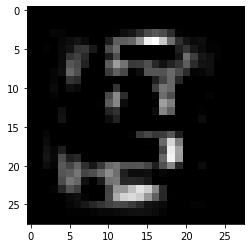

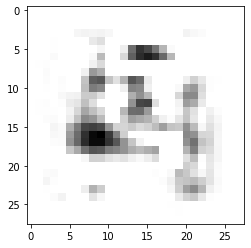

The optimal value is: 11.637150601199822
(28, 28)
2


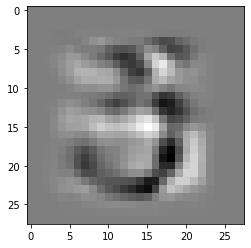

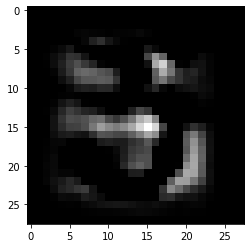

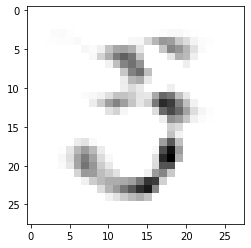

The optimal value is: 2317.974561680481
(28, 28)
1


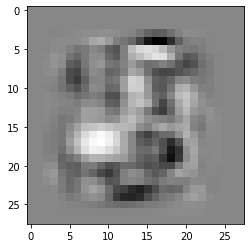

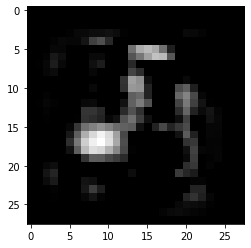

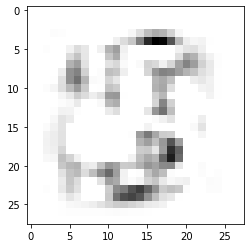

The optimal value is: 9733.507951083397
(28, 28)
0


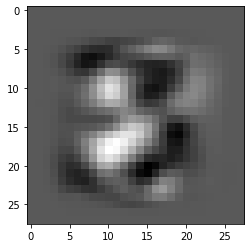

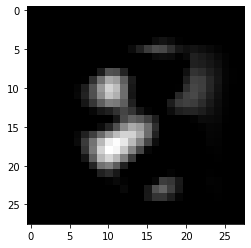

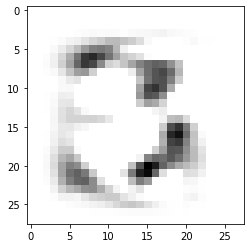

End
Train accuracy:
0.9554973821989529
Test Accuracy:
0.9633507853403142


total test accuracy=0.9633507853403142




In [27]:
n = Xtrain.shape[0]
i = 0
k = 1
r = int(n/5)
total_correct = 0
total_total = 0
total_accuracy = 0
while(i < k):
    print(f"{i} fold")
    if ((i+1)*r>n):
        print("lower the test %")
        break
    Xtra1 = Xtrain[0 : r*i]
    Ytra1 = ytrain[0 : r*i]
    Xtra2 = Xtrain[r*(i+1) : ]
    Ytra2 = ytrain[r*(i+1) : ]
    Xtra = np.concatenate((Xtra1, Xtra2), axis=0)
    Ytra = np.concatenate((Ytra1, Ytra2), axis=0)
    Xtest = Xtrain[r*i : r*(i+1)]
    Ytest = ytrain[r*i : r*(i+1)]
    model = train(Xtra,Ytra,2,100,'L1','L1')
    ypred = model.forward(Xtest)
    acc = accuracy(ypred,Ytest)
    total_accuracy += acc
    print('Test Accuracy:')
    print(acc)
    i+=1
    print('\n')
print(f"total test accuracy={total_accuracy/k}\n\n")

0 fold
Start
The optimal value is: 10320.12239408566
(28, 28)
The optimal value is: 3687.723203120462
(28, 28)
The optimal value is: 3516.593220213706
(28, 28)
The optimal value is: 1908.1962431839272
(28, 28)
The optimal value is: 3516.59322021371
(28, 28)
The optimal value is: 2279.5703314686866
(28, 28)
The optimal value is: 2173.9193682603855
(28, 28)
The optimal value is: 2680.1659165797328
(28, 28)
The optimal value is: 2680.1659165797278
(28, 28)
The optimal value is: 11.637150601199526
(28, 28)
The optimal value is: 2680.1659165797337
(28, 28)
The optimal value is: 11.63715060119954
(28, 28)
Recursion Done
The optimal value is: 1908.1962431839233
(28, 28)
3


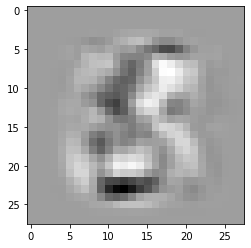

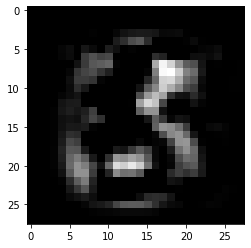

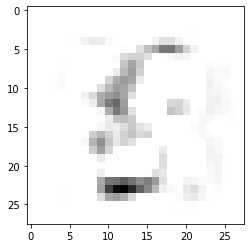

The optimal value is: 3516.593220213716
(28, 28)
3


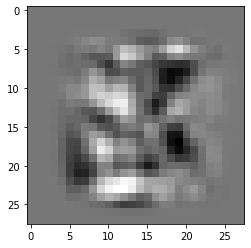

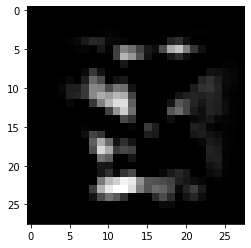

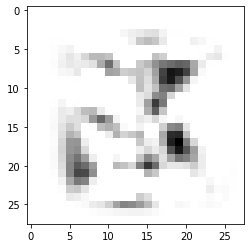

The optimal value is: 3103.3848100302976
(28, 28)
2


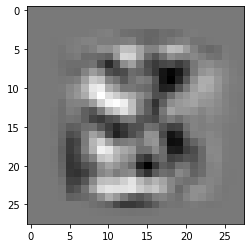

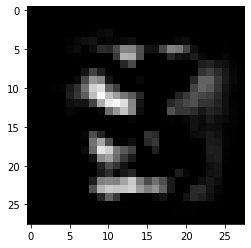

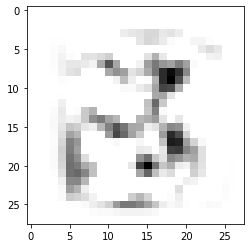

The optimal value is: 2173.9193682603873
(28, 28)
3


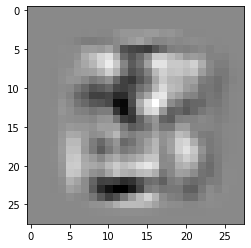

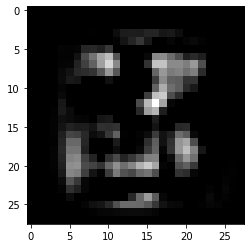

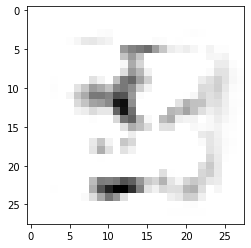

The optimal value is: 2279.5703314686943
(28, 28)
2


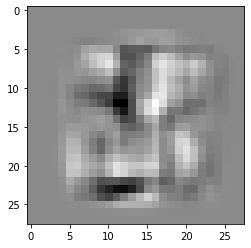

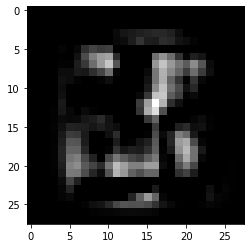

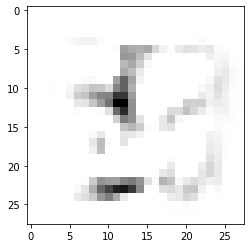

The optimal value is: 3225.647952529027
(28, 28)
1


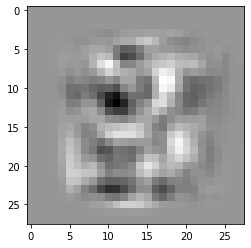

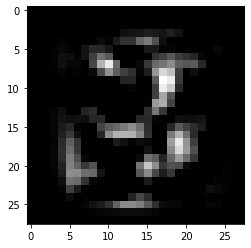

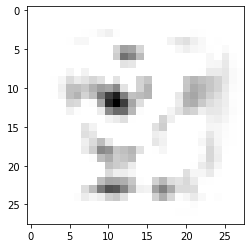

The optimal value is: 11.637150601199442
(28, 28)
3


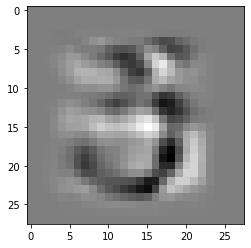

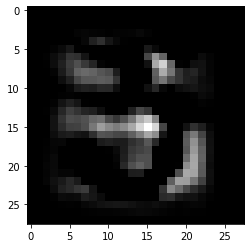

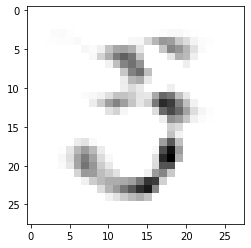

The optimal value is: 2680.165916579735
(28, 28)
3


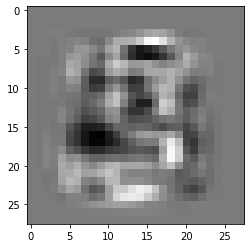

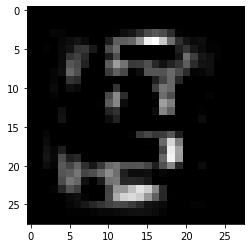

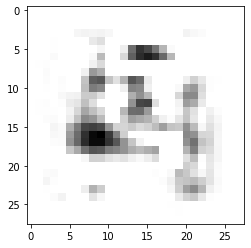

The optimal value is: 2317.9745616804785
(28, 28)
2


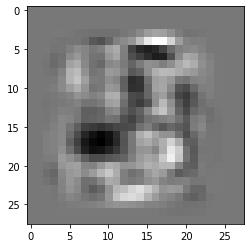

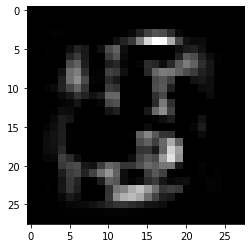

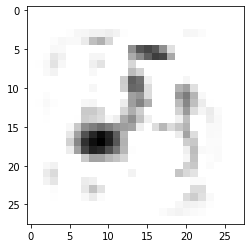

The optimal value is: 11.637150601199675
(28, 28)
2


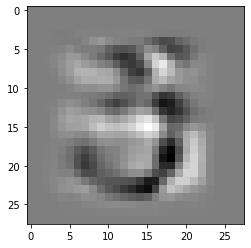

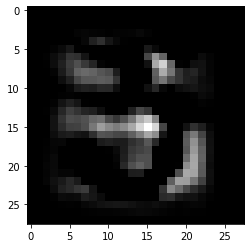

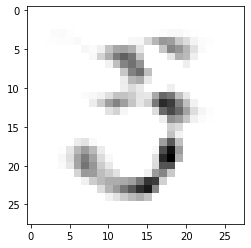

The optimal value is: 2317.9745616804794
(28, 28)
1


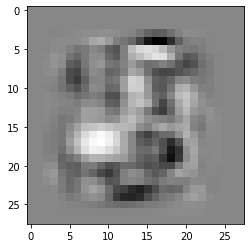

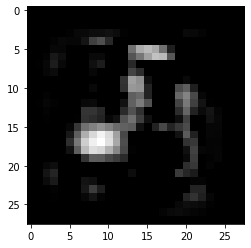

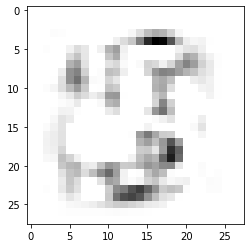

The optimal value is: 9244.812456687341
(28, 28)
0


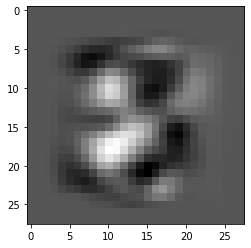

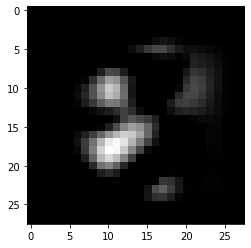

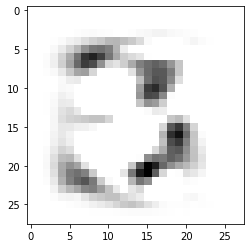

End
Train accuracy:
0.9568062827225131
Test Accuracy:
0.9633507853403142


total test accuracy=0.9633507853403142




In [28]:
n = Xtrain.shape[0]
i = 0
k = 1
r = int(n/5)
total_correct = 0
total_total = 0
total_accuracy = 0
while(i < k):
    print(f"{i} fold")
    if ((i+1)*r>n):
        print("lower the test %")
        break
    Xtra1 = Xtrain[0 : r*i]
    Ytra1 = ytrain[0 : r*i]
    Xtra2 = Xtrain[r*(i+1) : ]
    Ytra2 = ytrain[r*(i+1) : ]
    Xtra = np.concatenate((Xtra1, Xtra2), axis=0)
    Ytra = np.concatenate((Ytra1, Ytra2), axis=0)
    Xtest = Xtrain[r*i : r*(i+1)]
    Ytest = ytrain[r*i : r*(i+1)]
    model = train(Xtra,Ytra,3,100,'L1','L1')
    ypred = model.forward(Xtest)
    acc = accuracy(ypred,Ytest)
    total_accuracy += acc
    print('Test Accuracy:')
    print(acc)
    i+=1
    print('\n')
print(f"total test accuracy={total_accuracy/k}\n\n")

0 fold
Start
The optimal value is: 1036.000539269184
(28, 28)
The optimal value is: 370.53718468798047
(28, 28)
The optimal value is: 269.7301803577708
(28, 28)
Recursion Done
The optimal value is: 370.5371846879808
(28, 28)
1


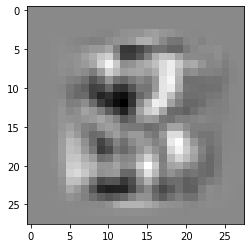

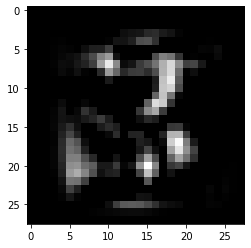

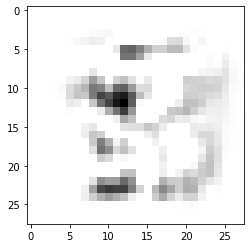

The optimal value is: 269.7301803577701
(28, 28)
1


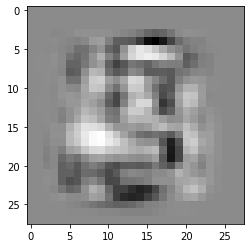

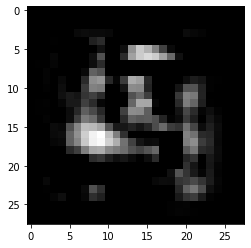

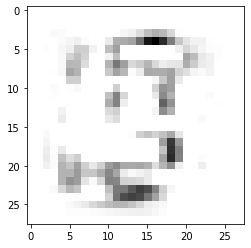

The optimal value is: 1036.000526970726
(28, 28)
0


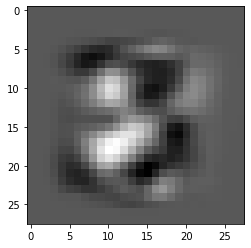

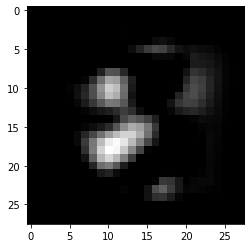

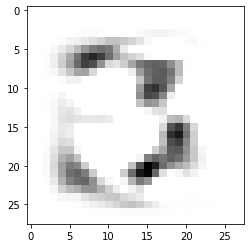

End
Train accuracy:
0.9528795811518325
Test Accuracy:
0.9633507853403142


total test accuracy=0.9633507853403142




In [31]:
XALL = mnist.train_images()[:5000]/255
yALL = mnist.train_labels().reshape(-1,1)[:5000].astype(np.int8)
y0 = (yALL == 3)
y2 = (yALL == 8)
ytot = y0 + y2
Xtrain = XALL[ytot.reshape(-1)]
ytrain = (yALL[ytot.reshape(-1)] -5.5)/2.5


n = Xtrain.shape[0]
i = 0
k = 1
r = int(n/5)
total_correct = 0
total_total = 0
total_accuracy = 0
while(i < k):
    print(f"{i} fold")
    if ((i+1)*r>n):
        print("lower the test %")
        break
    Xtra1 = Xtrain[0 : r*i]
    Ytra1 = ytrain[0 : r*i]
    Xtra2 = Xtrain[r*(i+1) : ]
    Ytra2 = ytrain[r*(i+1) : ]
    Xtra = np.concatenate((Xtra1, Xtra2), axis=0)
    Ytra = np.concatenate((Ytra1, Ytra2), axis=0)
    Xtest = Xtrain[r*i : r*(i+1)]
    Ytest = ytrain[r*i : r*(i+1)]
    model = train(Xtra,Ytra,1,10,'L1','L1')
    ypred = model.forward(Xtest)
    acc = accuracy(ypred,Ytest)
    total_accuracy += acc
    print('Test Accuracy:')
    print(acc)
    i+=1
    print('\n')
print(f"total test accuracy={total_accuracy/k}\n\n")